In [1]:
import numpy as np
import math
import Helper_functions as Hf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

#plt.rc('animation', html='html5')


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

#### ND = nondimensional, the dimensionless parameters for the model ###

c22h = 9                            # ND 2nd baroclinic gravity wave speed squared
c12h = 10                           # ND 1st baroclinic gravity wave speed squared
H1H2 = 1                            # ND upper to lower layer height ratio
Bt = (1**2)/2/(30**2)               # ND scaled beta Ld2^2/4a^2
Br2 = 1.5                           # ND scaled storm size: Burger number Ld2^2/Rst^2
p1p2 = 0.95                         # ND upper to lower layer density ratio
tstf = 48                           # ND storm duration tst*f0
tstpf= 60                           # ND period between forced storms tstp*f0
tradf= 2000                         # ND Newtonian damping of layer thickness trad*f0
Ar = 0.15                           # ND areal storm coverage
Re = 5e4                            # ND Reynolds number
Wsh = 0.03/2                        # ND convective Rossby number


#### Derived Quantities ###

gm = p1p2*c22h/c12h*H1H2            # ND reduced gravity
aOLd = np.sqrt(1/Bt/2);             # ND planetary radius to deformation radius ratio
L = 3*np.pi/9*aOLd;                 # ND num = ceil(numfrc.*L.^2./Br2);
num = round(Ar*(L**2)*Br2/np.pi)    # number of storms
deglim = 90-3*L/2*aOLd*180/np.pi;   # domain size [degrees]

### Enginneering Params ###
  
AB = 2                             # Order of Adams-Bashforth scheme (2 or 3) 
layers = 2.5                        # number of layers (2 or 2.5)
n = 2                              # Order of Laplacian; '2' for hyperviscosity
kappa = 1e-6
ord = 2                             # Must equal 1 for Glenn's order, otherwise for Sadourney's
tmax = 20000
spongedrag1 = 0.1
spongedrag2 = 0.1



sims = 1 # number of simulations you want to run

In [2]:
"""
    Setting up parameters, this is the OEF_params file
"""
dx = 1/5  # L/N
dt = 1/(2**8)  # dx./(10.*c1)
dtinv = 1/dt
sampfreq = 5
tpl = sampfreq*dtinv

N = math.ceil(L/dx)  # ceil(10./9*pi*1./sqrt(Bt))
L = N*dx

l = np.concatenate((np.array([N]), np.arange(1, N)))
l2 = np.concatenate((np.arange(N-1, N+1), np.arange(1, N-1)))
r = np.concatenate((np.arange(2, N+1), np.array([1])))
r2 = np.concatenate((np.arange(3, N+1), np.arange(1, 3)))

# h B grid
x, y = np.meshgrid(np.arange(0.5, N)*dx-L/2, np.arange(0.5, N)*dx-L/2)
H = 1 + 0*x
eta = 0*x
h1 = 0*x + 1
h2 = 0*x + 1


# u grid
x, y = np.meshgrid(np.arange(0, N)*dx-L/2, np.arange(0.5, N)*dx-L/2)
u1 = 0*x*y
u2 = u1


# v grid
x, y = np.meshgrid(np.arange(0.5, N)*dx-L/2, np.arange(0, N)*dx-L/2)
v1 = 0*x*y
v2 = v1


# zeta grid
x, y = np.meshgrid(np.arange(0, N)*dx-L/2, np.arange(0, N)*dx-L/2)
rdist = np.sqrt(x**2 + y**2)
outerlim = L/2 - 0.5
rlim = (rdist <= outerlim).astype(float)


sponge1 = np.ones(N) * np.maximum(rdist - outerlim, 0)
sponge1 = sponge1 / np.max(sponge1)
spdrag1 = spongedrag1 * sponge1

sponge2 = np.ones(N) * np.maximum(rdist - outerlim, 0)
sponge2 = sponge2 / np.max(sponge2)
spdrag2 = spongedrag2 * sponge2

In [3]:
"""
    Setting up modes for the simulation, OEF_modes file

    TODO: Implement more than mode 1
"""

locs=Hf.paircountN2(num,N-1)
mode = 1

#locs = np.array([[79,125]])

match mode:

    case 1:
        pulse = 'off'

        wlayer = Hf.pairshapeN2(locs, x, y, Br2, Wsh, N, dx)
        Wmat = Hf.pairfieldN2(L, dx, h1, wlayer) 
        
        Wmatorig = Wmat
        
        tpulseper = tstpf
        tpulsedur = tstf
        tclock = 0

        FreeGrid = np.sum(spdrag1 == 0) / (N**2)



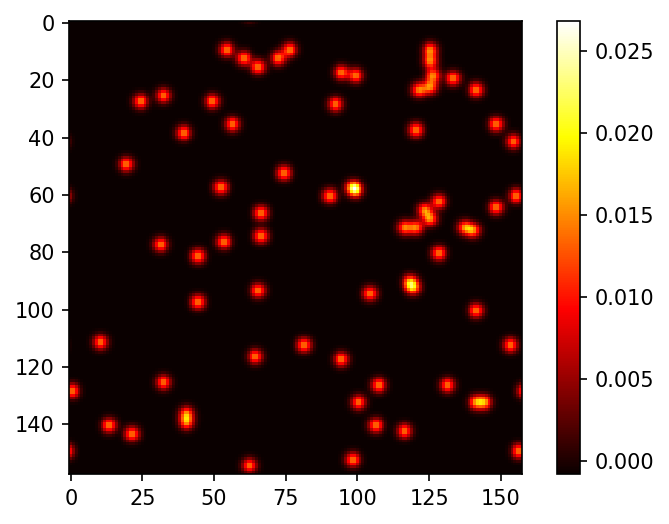

In [4]:
plt.imshow(Wmat, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:

t = 0
tc = 0

# test
uhatvec = 0
del2psivec = 0
psi2vec = 0
CFL1vec = 0
CFL2vec = 0

# TIME STEPPING
if AB == 2:
    u1_p = u1.copy()
    v1_p = v1.copy()
    h1_p = h1.copy()
    u2_p = u2.copy()
    v2_p = v2.copy()
    h2_p = h2.copy()

if AB == 3:
    u1_p = np.zeros_like(u1)
    v1_p = np.zeros_like(v1)
    h1_p = np.zeros_like(h1)
    u2_p = np.zeros_like(u2)
    v2_p = np.zeros_like(v2)
    h2_p = np.zeros_like(h2)
    
    u1sq = np.zeros_like(u1)
    u2sq = np.zeros_like(u2) 
    v1sq = np.zeros_like(v1)
    v2sq = np.zeros_like(v2)

ts = []
hm = []  # height max min!
psi2 = np.zeros_like(x)
dhdt = psi2.copy()
pv1 = psi2.copy()
pv2 = psi2.copy()
zeta1 = psi2.copy()
zeta2 = psi2.copy()
B2 = psi2.copy()
B1p = B2.copy()
pv1 = B2.copy()
pv2 = B2.copy()


#  u  h,B
#  z  v
ii = 0
zeta1mat = []
zeta2mat = []
h1mat = []
h2mat = []
Wpulsemat = []
u1mat = []
u2mat = []
v1mat = []
v2mat = []

# tpl = 25*dtinv

while t <= tmax + dt / 2:  # tmax+dt/2

    # TIME STEPPING
    if AB == 2:
        tmp = u1.copy()
        u1 = 1.5 * u1 - 0.5 * u1_p
        u1_p = tmp  #
        tmp = u2.copy()
        u2 = 1.5 * u2 - 0.5 * u2_p
        u2_p = tmp  #
        tmp = v1.copy()
        v1 = 1.5 * v1 - 0.5 * v1_p
        v1_p = tmp  
        tmp = v2.copy()
        v2 = 1.5 * v2 - 0.5 * v2_p
        v2_p = tmp  
        tmp = h1.copy()
        h1 = 1.5 * h1 - 0.5 * h1_p
        h1_p = tmp
        if layers == 2.5:
            tmp = h2.copy()
            h2 = 1.5 * h2 - 0.5 * h2_p
            h2_p = tmp

    if AB == 3:
        if tc > 1:
            u1s = u1.copy()
            u1 = 23 / 12 * u1 - 16 / 12 * u1_p + 5 / 12 * u1_pp
            u1_pp = u1_p.copy()
            u1_p = u1s.copy()
            v1s = v1.copy()
            v1 = 23 / 12 * v1 - 16 / 12 * v1_p + 5 / 12 * v1_pp
            v1_pp = v1_p.copy()
            v1_p = v1s.copy()
            h1s = h1.copy()
            h1 = 23 / 12 * h1 - 16 / 12 * h1_p + 5 / 12 * h1_pp
            h1_pp = h1_p.copy()
            h1_p = h1s.copy()
            u2s = u2.copy()
            u2 = 23 / 12 * u2 - 16 / 12 * u2_p + 5 / 12 * u2_pp
            u2_pp = u2_p.copy()
            u2_p = u2s.copy()
            v2s = v2.copy()
            v2 = 23 / 12 * v2 - 16 / 12 * v2_p + 5 / 12 * v2_pp
            v2_pp = v2_p.copy()
            v2_p = v2s.copy()
            if layers == 2.5:
                h2s = h2.copy()
                h2 = 23 / 12 * h2 - 16 / 12 * h2_p + 5 / 12 * h2_pp
                h2_pp = h2_p.copy()
                h2_p = h2s.copy()

    # add friction
    du1dt = Hf.viscND(u1, Re, n, l, l2, r, r2,dx)    
    du2dt = Hf.viscND(u2, Re, n, l, l2, r, r2,dx)
    dv1dt = Hf.viscND(v1, Re, n, l, l2, r, r2,dx)
    dv2dt = Hf.viscND(v2, Re, n, l, l2, r, r2,dx)
    
    if spongedrag1 > 0:
        du1dt = du1dt - spdrag1 * (u1)
        du2dt = du2dt - spdrag2 * (u2)
        dv1dt = dv1dt - spdrag1 * (v1)
        dv2dt = dv2dt - spdrag2 * (v2)

    # absolute vorticity
    zeta1 = 1 - Bt * rdist ** 2 + (1 / dx) * (v1 - np.roll(v1, 1, axis=1) + np.roll(u1, 1, axis=0) - u1)  # used to be just 'f'
    zeta2 = 1 - Bt * rdist ** 2 + (1 / dx) * (v2 - np.roll(v2, 1, axis=1) + np.roll(u2, 1, axis=0) - u2)  #

    # add vorticity flux, zeta*u
    zv1 = zeta1 * (v1 + np.roll(v1, 1, axis=1))
    zv2 = zeta2 * (v2 + np.roll(v2, 1, axis=1))

    du1dt = du1dt + 0.25 * (zv1 + np.roll(zv1, -1, axis=0))
    du2dt = du2dt + 0.25 * (zv2 + np.roll(zv2, -1, axis=0))

    zu1 = zeta1 * (u1 + np.roll(u1, 1, axis=0))
    zu2 = zeta2 * (u2 + np.roll(u2, 1, axis=0))

    dv1dt = dv1dt - 0.25 * (zu1 + np.roll(zu1, -1, axis=1))
    dv2dt = dv2dt - 0.25 * (zu2 + np.roll(zu2, -1, axis=1))


    B1p, B2p = Hf.BernN2(u1, v1, u2, v2, gm, c22h, c12h, h1, h2, ord, r)

    # add -grad B primes
    du1dtsq = du1dt - (1 / dx) * (B1p - np.roll(B1p, 1, axis=1))  # A1
    du2dtsq = du2dt - (1 / dx) * (B2p - np.roll(B2p, 1, axis=1))  # B1

    dv1dtsq = dv1dt - (1 / dx) * (B1p - np.roll(B1p, 1, axis=0))  # A2
    dv2dtsq = dv2dt - (1 / dx) * (B2p - np.roll(B2p, 1, axis=0))  # B2
    
    if AB == 2:
        # step forward squiggle velocities
        u1sq = u1_p + dt * du1dtsq
        u2sq = u2_p + dt * du2dtsq

        v1sq = v1_p + dt * dv1dtsq
        v2sq = v2_p + dt * dv2dtsq

    if mode == 1:
        if t % tpulseper == 0 and t != 0:
            # remember this will only happen once, not for a duration
            # need to set a 'clock'
            tclock = t
            locs = Hf.paircountN2(num, N-1)
            wlayer = Hf.pairshapeN2(locs, x, y, Br2, Wsh, N, dx)
            newWmat = Hf.pairfieldN2(L, dx, h1, wlayer)

        if tclock + tpulsedur > t and tclock != 0:
            Wmat = newWmat
        elif t > tpulsedur:
            Wmat = np.zeros_like(x * y)
            tclock = 0

    Fx1 = Hf.xflux(h1, u1, dx, dt, l, r) - kappa / dx * (h1 - np.roll(h1, 1, axis=1))
    Fy1 = Hf.yflux(h1, v1, dx, dt, l, r) - kappa / dx * (h1 - np.roll(h1, 1, axis=0))
    dh1dt = -(1 / dx) * (np.roll(Fx1, -1, axis=1) - Fx1 + np.roll(Fy1, -1, axis=0) - Fy1)

    if layers == 2.5:
        Fx2 = Hf.xflux(h2, u2, dx, dt, l, r) - kappa / dx * (h2 - np.roll(h2, 1, axis=1))
        Fy2 = Hf.yflux(h2, v2, dx, dt, l, r) - kappa / dx * (h2 - np.roll(h2, 1, axis=0))
        dh2dt = -(1 / dx) * (np.roll(Fx2, -1, axis=1) - Fx2 + np.roll(Fy2, -1, axis=0) - Fy2)

    if tradf > 0:
        dh1dt = dh1dt - 1 / tradf * (h1 - 1)
        dh2dt = dh2dt - 1 / tradf * (h2 - 1)
    
    if mode == 1:
        dh1dt = dh1dt + Wmat
        if layers == 2.5:
            dh2dt = dh2dt - H1H2 * Wmat
            
    if AB == 3:  # needs RK steps to start
        if tc >= 1:  # RK steps here
            du1dt1 = u1sq + dt * du1dtsq  # these steps already have the new
            du2dt1 = u2sq + dt * du2dtsq  # velocity with the pressure correction
            dv1dt1 = v1sq + dt * dv1dtsq
            dv2dt1 = v2sq + dt * dv2dtsq
            dh1dt1 = h1 + dt * dh1dt
            if layers == 2.5:
                dh2dt1 = h2 + dt * dh2dt

            u1_pp = u1_p.copy()
            u1_p = u1.copy()
            v1_pp = v1_p.copy()
            v1_p = v1.copy()
            u2_pp = u2_p.copy()
            u2_p = u2.copy()
            v2_pp = v2_p.copy()
            v2_p = v2.copy()
            h1_pp = h1_p.copy()
            h1_p = h1.copy()
            if layers == 2.5:
                h2_pp = h2_p.copy()
                h2_p = h2.copy()

            u1sq = u1sq + dt / 2 * (du1dtsq + du1dt1)  # this needs to be done PRE press.corr.
            u2sq = u2sq + dt / 2 * (du2dtsq + du2dt1)
            v1sq = v1sq + dt / 2 * (dv1dtsq + dv1dt1)
            v2sq = v2sq + dt / 2 * (dv2dtsq + dv2dt1)
            h1 = h1 + dt / 2 * (dh1dt + dh1dt1)
            if layers == 2.5:
                h2 = h2 + dt / 2 * (dh2dt + dh2dt1)

        else:
            h1 = h1_p + dt * dh1dt
            if layers == 2.5:
                h2 = h2_p + dt * dh2dt

    if AB == 2:
        h1 = h1_p + dt * dh1dt
        if layers == 2.5:
            h2 = h2_p + dt * dh2dt
            # eta = (g31.*h1+g32.*h2)./g;

    u1 = u1sq
    u2 = u2sq
    v1 = v1sq
    v2 = v2sq
        
    if tc % tpl == 0:
        print(f'{t}, mean h1 is {np.mean(np.mean(h1))}')
        ii += 1
        ts.append(t)
    
        u1mat.append(u1)
        u2mat.append(u2)
        v1mat.append(v1)
        v2mat.append(v2)
        h1mat.append(h1)
        h2mat.append(h2)
        zeta1mat.append(zeta1)
        zeta2mat.append(zeta2)
        
        Wpulsemat.append(Wmat)

    if math.isnan(h1[0,0]):
        break

    tc += 1
    t = tc*dt


0, mean h1 is 1.0
5.0, mean h1 is 1.0
10.0, mean h1 is 1.0000000000000002
15.0, mean h1 is 1.0000000000000002
20.0, mean h1 is 1.0000000000000002
25.0, mean h1 is 1.0000000000000002
30.0, mean h1 is 1.0
35.0, mean h1 is 1.0
40.0, mean h1 is 1.0000000000000002
45.0, mean h1 is 1.0
50.0, mean h1 is 1.0
55.0, mean h1 is 1.0
60.0, mean h1 is 1.0
65.0, mean h1 is 1.0
70.0, mean h1 is 1.0
75.0, mean h1 is 1.0
80.0, mean h1 is 1.0
85.0, mean h1 is 1.0
90.0, mean h1 is 1.0000000000000002
95.0, mean h1 is 1.0
100.0, mean h1 is 1.0
105.0, mean h1 is 1.0
110.0, mean h1 is 0.9999999999999999
115.0, mean h1 is 1.0
120.0, mean h1 is 1.0000000000000002
125.0, mean h1 is 1.0000000000000002
130.0, mean h1 is 1.0000000000000002
135.0, mean h1 is 1.0
140.0, mean h1 is 1.0
145.0, mean h1 is 1.0
150.0, mean h1 is 1.0
155.0, mean h1 is 0.9999999999999999
160.0, mean h1 is 0.9999999999999999
165.0, mean h1 is 1.0
170.0, mean h1 is 1.0
175.0, mean h1 is 0.9999999999999999
180.0, mean h1 is 1.0
185.0, mean h1 

In [ ]:
plt.imshow(u1mat[0], cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
h1mat[0]

In [ ]:
img = h2mat
frames = [] 
fig = plt.figure()
for i in range(len(img)):
    frames.append([plt.imshow(img[i], cmap='bwr', animated=True)])
    
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                    repeat_delay=1000)

plt.colorbar()
#ani.save("movie.mp4")
HTML(ani.to_html5_video())

In [ ]:
ani.save("zeta1FIRST.mp4")